In [1]:
import sys
import os
import numpy as np
import scipy.interpolate as interpolate
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sys.path.extend(['/Users/lynnej/otherRepos/CometGPs/notebooks'])
import alcdef_util as au

In [3]:
# Where is your data from ALCDF?
ddir = '/Users/lynnej/otherRepos/translate-cuss/data'

ALCDEF_16_Psyche_20180207_185754 block 0: (midpoint 2015-11-30, 09:44:00)
Observed in C, reporting V
Reported differential magnitudes
Times are light time corrected by -0.009812 (AVERAGE)
ALCDEF_16_Psyche_20180207_185754 block 1: (midpoint 2015-12-01, 09:02:00)
Observed in C, reporting V
Reported differential magnitudes
Times are light time corrected by -0.009806 (AVERAGE)
ALCDEF_16_Psyche_20180207_185754 block 2: (midpoint 2015-12-26, 06:16:00)
Observed in V, reporting V
Reported differential magnitudes
Times are light time corrected by -0.010166 (AVERAGE)


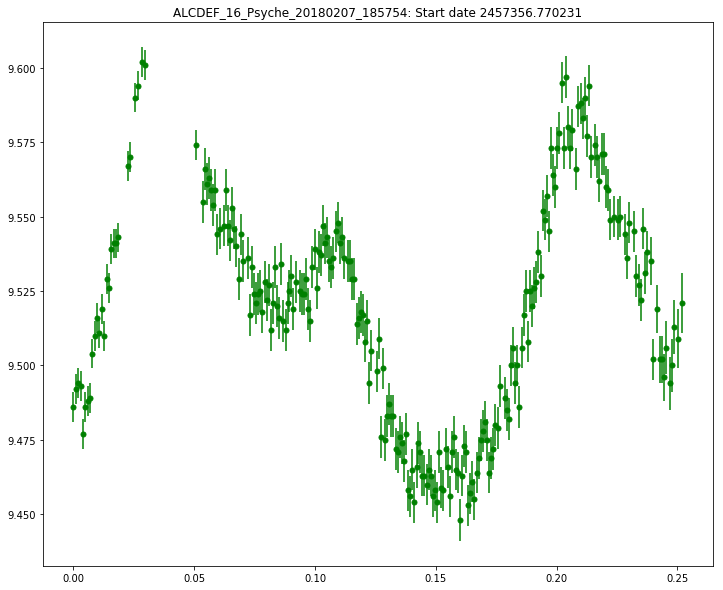

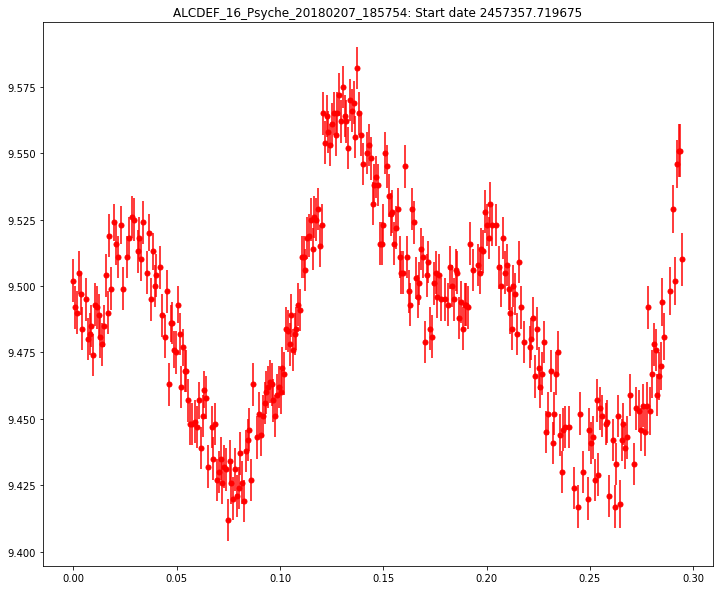

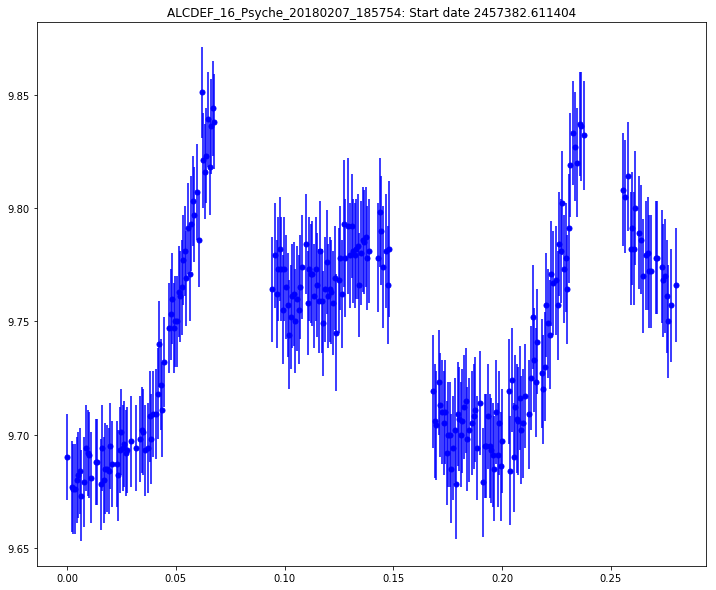

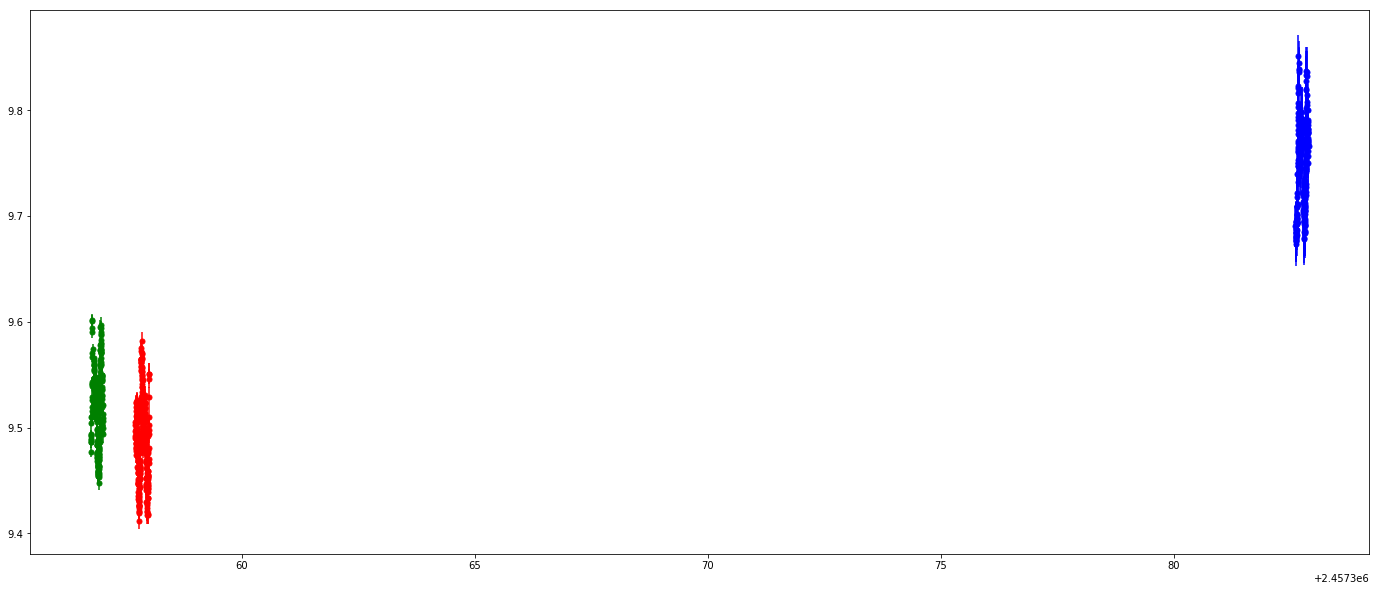

In [4]:
# Picked the Psyche LC data - they have two segments.
fname = 'ALCDEF_16_Psyche_20180207_185754.txt'
md, lc = au.read_alcdef(os.path.join(ddir, fname))
au.plot_lightcurve(md, lc, fname)

In [5]:
# Fit the LC data. "xi" gives me a way to hack the starting point, so that the end/start of the fit match up
# reasonably .. not perfectly though. (yes, this is a hack)
tstep = 0.5/60/24
xi = 15
fit_x = lc[0].JD.values[xi:] 
fit_y = lc[0].Mag.values[xi:]
f = interpolate.splrep(fit_x - fit_x[0], fit_y - fit_y[0], s=0.015)

(2457356.7702310001, 2457357.0222089998)

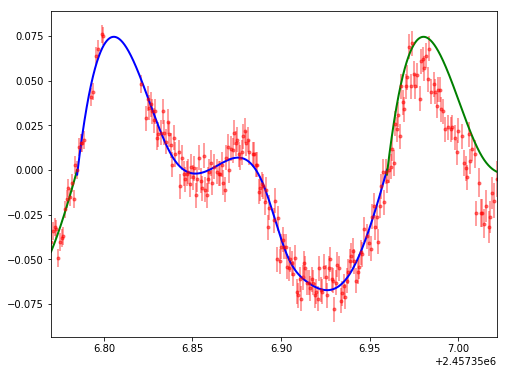

In [6]:
# The LCDB says Psyche has a rotation period of 4.196 HRs, so I'll use that for the period.
# I am a little confused on whether this is truly the rotation period or light curve period ... 
# Clearly there are two different peaks within this period, so that would indicate rotation period I think.
# But the second peak is so small..
# Chunk 1 
i = 0
period = 4.196/24.0
plt.figure(figsize=(8, 6))
plt.errorbar(lc[i].JD, lc[i].Mag - lc[i].Mag[xi], yerr=lc[i].DeltaMag, color='r', linestyle='', marker='.', alpha=0.5)
times = np.arange(0, period, 1/24./60./60.0)
offset = lc[0].JD[xi]
plt.plot(times + offset - period, interpolate.splev(times, f, der=0), color='g', linewidth=2)
plt.plot(times + offset, interpolate.splev(times, f, der=0), color='b', linewidth=2)
plt.plot(times + offset + period, interpolate.splev(times, f, der=0), color='g', linewidth=2)
plt.xlim(lc[i].JD.min(), lc[i].JD.max())

(2457357.7196749998, 2457358.0143320002)

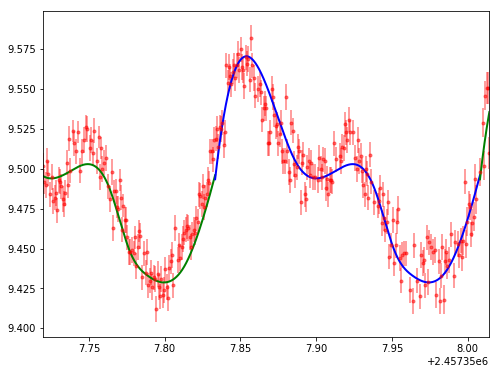

In [7]:
# Chunk 2
i = 1
offset = lc[i].JD[0] + period * 0.65
magoffset = lc[0].Mag[xi] - 0.03
plt.figure(figsize=(8, 6))
plt.errorbar(lc[i].JD, lc[i].Mag, yerr=lc[i].DeltaMag, color='r', linestyle='', marker='.', alpha=0.5)
plt.plot(times + offset - period, interpolate.splev(times, f, der=0) + magoffset, color='g', linewidth=2)
plt.plot(times + offset, interpolate.splev(times, f, der=0) + magoffset, color='b', linewidth=2)
plt.plot(times + offset + period, interpolate.splev(times, f, der=0) + magoffset, color='g', linewidth=2)
plt.xlim(lc[i].JD.min(), lc[i].JD.max())

Text(0,0.5,'Delta Magnitude')

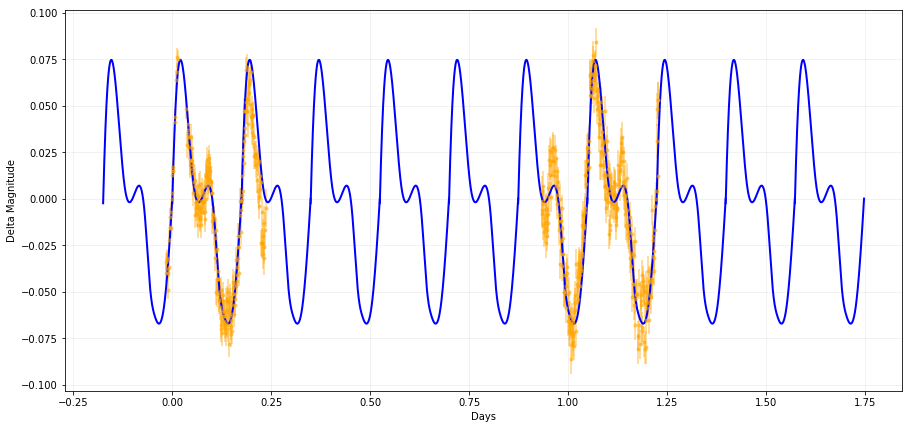

In [8]:
# This is two observing nights. Interesting to clearly see the number of unobserved rotations, no?
plt.figure(figsize=(15, 7))
offset = 0 
tstart = lc[0].JD[16]
for p in range(-1, 10):
    plt.plot(times + offset + p * period, interpolate.splev(times, f, der=0), color='b', linewidth=2)
i = 0
magoffset = - lc[i].Mag[xi]
plt.errorbar(lc[i].JD - tstart, lc[i].Mag + magoffset, yerr=lc[i].DeltaMag, color='orange', 
             linestyle='', marker='.', alpha=0.5)
i = 1
magoffset =  - lc[i].Mag[xi] - 0.02
plt.errorbar(lc[i].JD - tstart, lc[i].Mag + magoffset, yerr=lc[i].DeltaMag, color='orange', 
             linestyle='', marker='.', alpha=0.5)
plt.grid(True, alpha=0.2)
plt.xlabel('Days')
plt.ylabel('Delta Magnitude')

In [9]:
# a little function to simulate about 30 distinct nights of ZTF data (which would cross about 60 nights or so of time)
def spline_template(t, period=4.196/24.0, fudge=2.0):
    y = fudge * interpolate.splev(t % period, f, der=0)
    return y
    
def simulate_ZTF(lightcurve_template, mag_err=0.04):
    # Simulate ZTF visits
    ztf_times = []
    nnights = 30
    dnights = np.random.randint(3, 6, size=nnights)
    dnights[1::2] = 0 
    nights = np.zeros(nnights, float) + dnights
    nights = nights.cumsum()
    # After 1 month, given field rises 2 hours earlier
    # Let's say we start @ +/- 1 hour of midnight
    start_times = (np.random.random(nnights) * 2.0 - 1.0) * 60.0
    start_times[::2] = start_times[1::2]
    dtimes = np.random.randint(30, 51, size=nnights)
    dtimes[::2] = 0
    times = nights + (start_times  + dtimes) / 60.0 /  24.0 + (nights * -2./24./30.)
    #true_mags = fudge * interpolate.splev(times % period, f, der=0)
    true_mags = lightcurve_template(times)
    applied_mag_errs = np.random.normal(0, mag_err, size=len(times))
    mags = true_mags + applied_mag_errs
    mag_errs = np.zeros(len(mags), float) + mag_err
    return times, mags, mag_errs, applied_mag_errs

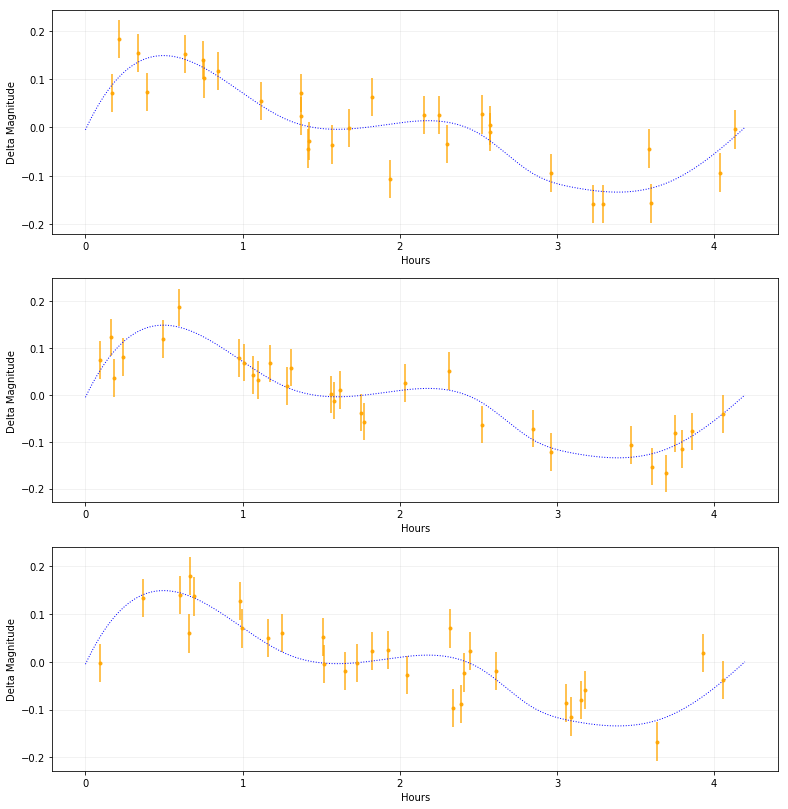

In [10]:
# Plot some instantiations, in a properly phased version.
fudge = 2
plt.figure(figsize=(13, 14))
for i in range(3):
    #plt.figure(figsize=(15, 7))
    plt.subplot(3,1,i+1)
    tt = np.arange(0, period, 1/24./60./60.0)
    ff = spline_template(tt)
    plt.plot(tt*24, ff, 'b', linewidth=1, linestyle=':')
    times, mags, mag_errs, ap_errs = simulate_ZTF(spline_template)
    with open('ztf_mags_%d.txt' % i, 'w') as zout:
        zout.write('Times Mags Mag_errs\n')
        for t, m, me in zip(times, mags, mag_errs):
            zout.write('%f %f %f\n' % (t, m, me))
    plt.errorbar((times % period)*24., mags, yerr=mag_errs, color='orange', linestyle='', marker='.', alpha=0.9)
    plt.grid(True, alpha=0.2)
    plt.xlabel('Hours')
    plt.ylabel('Delta Magnitude')
plt.savefig('phased_ztf.png')

Text(0,0.5,'Delta Magnitude')

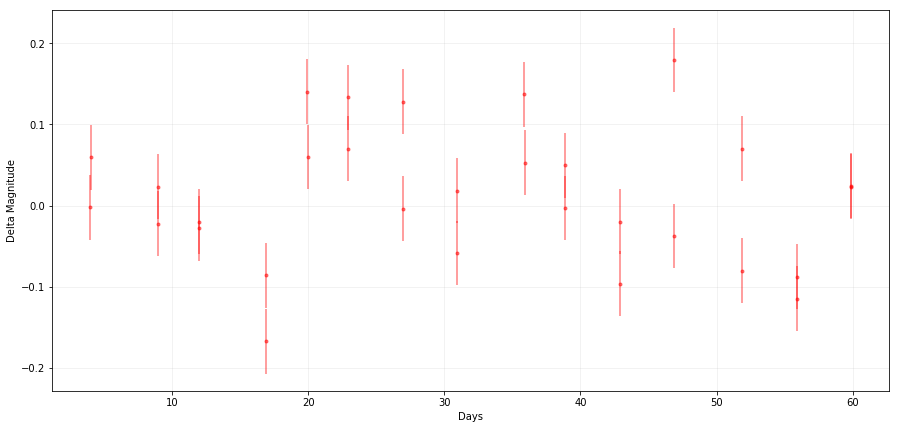

In [11]:
# Plot that last version, through all times
plt.figure(figsize=(15, 7))
tt = np.arange(0, period, 1/24./60./60.0)
ff = fudge * interpolate.splev(tt, f, der=0)
nperiods = int(np.ceil(times.max()/period))
plt.errorbar(times, mags, yerr=mag_errs, color='r', linestyle='', marker='.', alpha=0.5)
plt.grid(True, alpha=0.2)
plt.xlabel('Days')
plt.ylabel('Delta Magnitude')

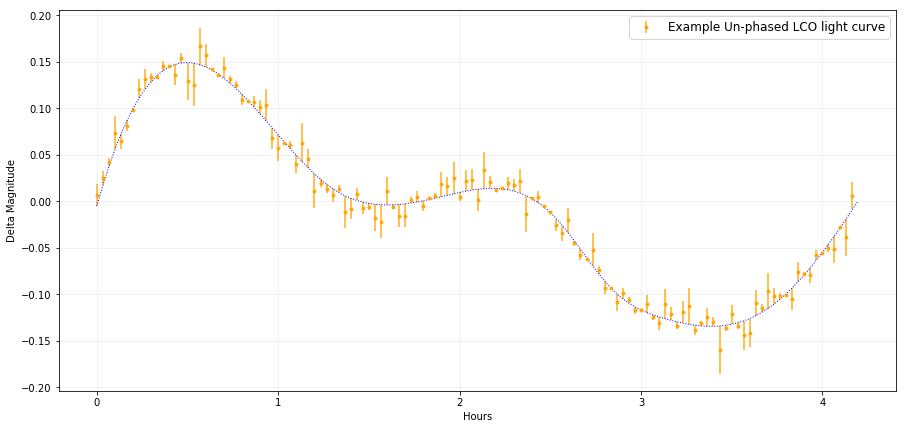

In [12]:
# The same template, observed @ LCO for 2 continuous periods.
lco_times = np.arange(0, period, 2./60./24.)
lco_true_mags = spline_template(lco_times)
lco_mag_errs = np.random.normal(0, 0.01, size=len(lco_times))
lco_mags = lco_true_mags + lco_mag_errs

plt.figure(figsize=(15, 7))
tt = np.arange(0, period, 1/24./60./60.0)
ff = spline_template(tt)
nperiods = int(np.ceil(times.max()/period))
plt.plot(tt*24., ff, 'b', linewidth=1, linestyle=':')
#plt.plot((tt+period)*24., ff, 'b', linewidth=1, linestyle=':')
plt.errorbar(lco_times*24.0, lco_mags, yerr=lco_mag_errs, 
             color='orange', linestyle='', marker='.', alpha=0.9,
            label='Example Un-phased LCO light curve')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1)
plt.grid(True, alpha=0.2)
plt.xlabel('Hours')
plt.ylabel('Delta Magnitude')
plt.savefig('lco_lc.png')

In [13]:
# Test some other methods ...
from gatspy import periodic

In [ ]:
best_ls_periods = []
best_ss_periods = []
for i in range(20):
    t, m, me, apme = simulate_ZTF(spline_template)
    modelLS = periodic.LombScargle(fit_period=True, Nterms=2, fit_offset=True)
    modelLS.optimizer.set(period_range=(1.0/24.0, 9.0/24.0), first_pass_coverage=10)
    modelLS.fit(t, m, me)
    best_ls_periods.append(modelLS.best_period*24.0)
    modelSS = periodic.SuperSmoother(fit_period=True)
    modelSS.optimizer.set(period_range=(1.0/24.0, 9.0/24.0), first_pass_coverage=10)
    modelSS.fit(t, m, me)
    best_ss_periods.append(modelSS.best_period*24.0)

Finding optimal frequency:
 - Estimated peak width = 0.107
 - Using 10 steps per peak; omega_step = 0.0107
 - User-specified period range:  0.042 to 0.38
 - Computing periods at 12558 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps
Finding optimal frequency:
 - Estimated peak width = 0.107
 - Using 10 steps per peak; omega_step = 0.0107
 - User-specified period range:  0.042 to 0.38
 - Computing periods at 12558 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps
Finding optimal frequency:
 - Estimated peak width = 0.102
 - Using 10 steps per peak; omega_step = 0.0102
 - User-specified period range:  0.042 to 0.38
 - Computing periods at 13206 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps
Finding optimal frequency:
 - Estimated peak width = 0.102
 - Using 10 steps per peak; omega_step = 0.0102
 - User-specified period range:  0.042 to 0.38
 - Computing periods at 13206 steps
Zooming-in on 5 candidate peaks:
 - Com

In [ ]:
for l, s in zip(best_ls_periods, best_ss_periods):
    print(l, s)
plt.figure(figsize=(6,6))
plt.plot(best_ls_periods, best_ss_periods, 'k.')
plt.grid(True, alpha=0.3)
plt.axvline(period*24.0, linestyle=':', color='b')
plt.axhline(period*24.0, linestyle=':', color='b')
plt.gca().set_aspect('equal', 'datalim')
plt.xlabel('LS period (hours)')
plt.ylabel('Supersmoother period (hours)')

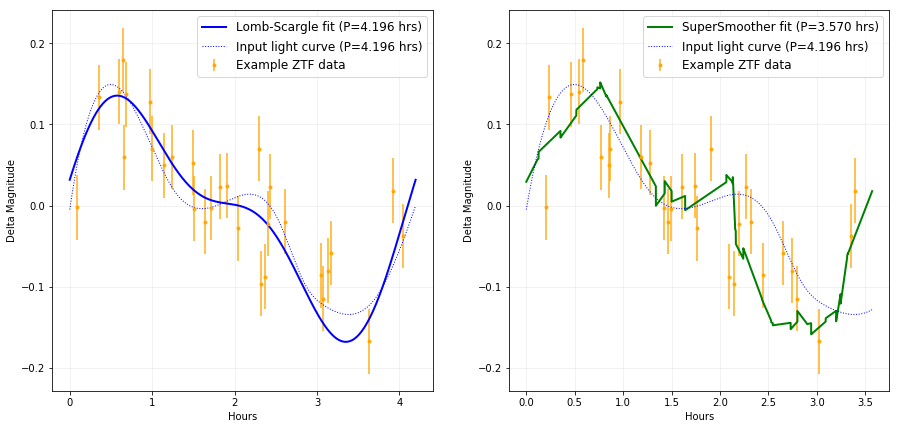

In [20]:
phase_period = modelLS.best_period
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
tt = np.arange(0, phase_period, 1/24./60./60.0)
ff = modelLS.predict(tt)
plt.plot(tt*24., ff, 'b', linewidth=2, linestyle='-', 
         label='Lomb-Scargle fit (P=%.3f hrs)' % (phase_period*24.0))
tt = np.arange(0, phase_period, 1/24./60./60.0)
ff = fudge * interpolate.splev(tt, f, der=0)
nperiods = int(np.ceil(times.max()/period))
plt.plot(tt*24., ff, 'b', linewidth=1, linestyle=':',
        label='Input light curve (P=%.3f hrs)' % (period*24.0))
plt.errorbar((times % modelLS.best_period)*24., mags, yerr=mag_errs, 
             color='orange', linestyle='', marker='.', alpha=0.9,
            label='Example ZTF data')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1)
plt.grid(True, alpha=0.2)
plt.xlabel('Hours')
plt.ylabel('Delta Magnitude')
plt.subplot(1,2,2)
phase_period = modelSS.best_period
tt = np.arange(0, phase_period, 1/24./60./60.0)
ff = modelSS.predict(tt)
plt.plot(tt*24, ff, 'g', linewidth=2, linestyle='-', 
         label='SuperSmoother fit (P=%.3f hrs)' % (phase_period*24.0))
tt = np.arange(0, phase_period, 1/24./60./60.0)
ff = fudge * interpolate.splev(tt, f, der=0)
nperiods = int(np.ceil(times.max()/period))
plt.plot(tt*24., ff, 'b', linewidth=1, linestyle=':',
        label='Input light curve (P=%.3f hrs)' % (period*24.0))
plt.errorbar((times % modelSS.best_period)*24., mags, yerr=mag_errs, 
             color='orange', linestyle='', marker='.', alpha=0.9,
            label='Example ZTF data')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1)
plt.grid(True, alpha=0.2)
plt.xlabel('Hours')
plt.ylabel('Delta Magnitude')
plt.savefig('LS-SS_fits.eps', format='eps')

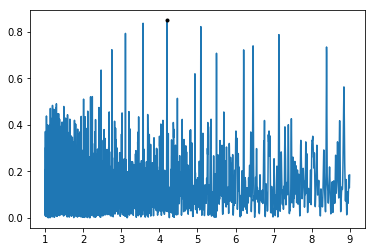

In [17]:
periods = np.arange(1.0/24.0, 9.0/24.0, 0.01/60/24.)
power = modelLS.periodogram(periods)
plt.plot(periods*24, power)
#periods = np.arange(3.9/24.0, 4.3/24.0, 0.001/60/24)
#power = modelLS.periodogram(periods)
#plt.plot(periods*24, power)
periods = period
power = modelLS.periodogram(periods)
plt.plot(periods*24, power, 'k.')

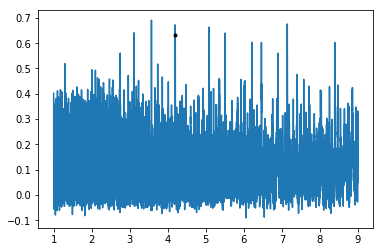

In [18]:
periods = np.arange(1.0/24.0, 9.0/24.0, 0.01/60/24.)
power = modelSS.periodogram(periods)
plt.plot(periods*24, power)
#periods = np.arange(3.9/24.0, 4.3/24.0, 0.001/60/24)
#power = modelSS.periodogram(periods)
#plt.plot(periods*24, power)
periods = period
power = modelSS.periodogram(periods)
plt.plot(periods*24, power, 'k.')